In [2]:
from getdata import GetDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [47]:
data_orig,target = GetDataset(CreateDataFrame=True).Outputdata()

In [60]:
#Interpolacion para que los datos en x1 sean x distantes
x = np.linspace(data_orig[0][0].min(),data_orig[0][0].max(),901)
temp = np.zeros((data_orig.shape[0],901))
for i in range(data_orig.shape[0]):
    temp[i,:] = np.interp(x,data_orig[i][0][:],data_orig[i][1][:])

In [61]:
temp.shape

(3090, 901)

In [103]:
# Creacion de arreglos matriciales 30x30 2 channels
data = np.zeros((temp.shape[0],temp.shape[1],2))
for i in range(data.shape[0]):
    data[i,:,0] = temp[i,:]
    data[i,:,1] = np.gradient(np.convolve(temp[i], np.ones(5)/5, mode='same'))

In [82]:
data[:,:,0]

array([[6.08214809e-03, 3.63343838e-03, 2.23557404e-03, ...,
        1.39978603e+02, 1.38813992e+02, 1.37649381e+02],
       [2.97113566e-03, 3.65105201e-03, 2.70457345e-03, ...,
        1.81756229e+02, 1.80646743e+02, 1.79537257e+02],
       [6.91251745e-03, 4.96095281e-03, 2.41421971e-03, ...,
        1.25976163e+02, 1.25224434e+02, 1.24472706e+02],
       ...,
       [5.05873349e-01, 7.25203774e-01, 2.78336615e-01, ...,
        6.95362302e+02, 6.57929494e+02, 6.20496685e+02],
       [1.14015381e-01, 2.69359997e-01, 3.14152209e-01, ...,
        4.13888700e+02, 3.91779975e+02, 3.69671251e+02],
       [2.17232391e-01, 9.97845503e-02, 1.14055937e-01, ...,
        1.36881423e+01, 1.34799157e+01, 1.32716892e+01]])

In [87]:
x_smoothed = np.convolve(data[0,:,0], np.ones(5)/5, mode='same')

In [112]:
from scipy.signal import savgol_filter
from pykalman import KalmanFilter
temp2 = savgol_filter(data[0,:,1], window_length=5, polyorder=1)
temp2.shape

(901,)

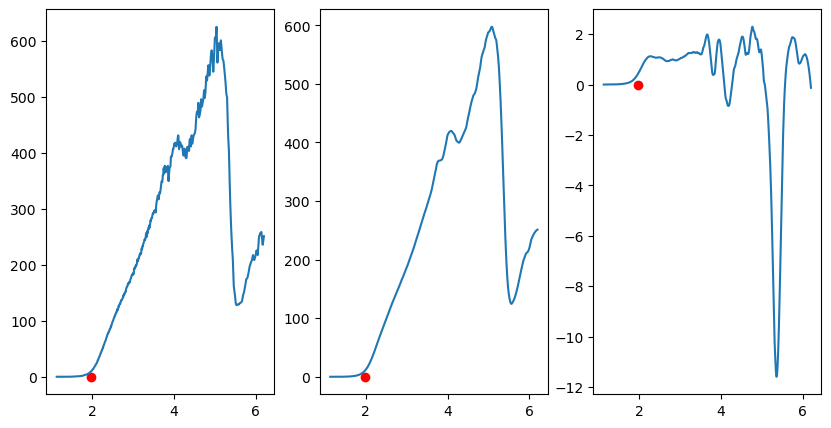

In [128]:


ID = 231
fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].plot(x, data[ID,:,0] )
axs[0].scatter(target[ID],0, color='red')

temp2 = savgol_filter(data[ID,:,0], window_length=50, polyorder=2)

axs[1].plot(x, temp2 )
axs[1].scatter(target[ID],0, color='red')

axs[2].plot(x, savgol_filter(np.gradient(temp2), window_length=50, polyorder=2))
axs[2].scatter(target[ID],0, color='red')
"""
temp12 = np.convolve(data[ID,:,0], np.ones(5)/5, mode='same')
temp21 =  np.convolve(temp12, np.ones(5)/5, mode='same')
axs[2].plot(x, temp21)
axs[2].scatter(target[ID],0, color='red')

axs[3].plot(x,np.gradient(temp21))
axs[3].scatter(target[ID],0, color='red')
"""
plt.show()


In [6]:
torch.manual_seed(42)
shuffle_idx = torch.randperm(3090, dtype = torch.long)
data_shuffle = data[shuffle_idx]
target_shuffle = target[shuffle_idx]
shuffle_idx

tensor([2082, 2966, 2862,  ...,  847, 2232, 1707])

In [180]:
target_shuffle[0]

2.08

In [7]:
train_input, train_target = data_shuffle[:2472,:,:,:], target_shuffle[:2472]
val_input, val_target = data_shuffle[2472:2781,:,:,:], target_shuffle[2472:2781]
test_input, test_target = data_shuffle[2781:,:,:,:], target_shuffle[2781:]

In [183]:
val_target[0]

3.32

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
train_input = torch.tensor(train_input, dtype = torch.float, device=device)
train_target = torch.tensor(train_target, dtype = torch.float, device=device)

test_input = torch.tensor(test_input, dtype = torch.float, device=device)
test_target = torch.tensor(test_target, dtype = torch.float, device=device)

val_input = torch.tensor(val_input, dtype = torch.float, device=device)
val_target = torch.tensor(val_target, dtype = torch.float, device=device)

In [10]:
train_input = train_input.permute(0,3,1,2)
test_input = test_input.permute(0,3,1,2)
val_input = val_input.permute(0,3,1,2)


In [11]:
train_input.shape
val_input.shape
test_input.shape

torch.Size([309, 2, 30, 30])

In [41]:
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from tqdm import tqdm
import math
from torchsummary import summary
from IPython.display import clear_output

class Lineal_Net(nn.Module):
    def __init__(self, criterion, optimizer):
        super(Lineal_Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=(1,5), stride=(1,5), padding=0) #30x6
        self.conv2 = nn.Conv2d(6, 12, kernel_size=(1,3), stride=(1,3), padding=0) #30x2
        self.conv3 = nn.Conv2d(12, 24, kernel_size=(1,2), stride=(1,1), padding=0) #30x1
        self.fc1 = nn.Linear(24 * 30 * 1, 64)
        self.fc2 = nn.Linear(64,1)

        self.criterion = criterion
        self.optimizer = optimizer


    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #x = F.max_pool2d(x, kernel_size=2, stride=2)
        #x = x.view(-1, 64 * 30 * 1)
        x = x.reshape(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
    def train(self, x, y, epochs, lr, batch_size):

        optimizer = self.optimizer(self.parameters(), lr=lr)
        epoch_loss = []
        total_batches = math.floor(y.shape[0]/batch_size)

        for e in range(epochs):
            pbar = tqdm(total= total_batches, desc=f'Epoch {e+1}/{epochs}', position=0, leave=True)
            acc_loss = 0.0
            shuffle_idx = torch.randperm(y.size(0), dtype = torch.long)
            batches = torch.split(shuffle_idx, batch_size)
            
            for batch in batches:

                input_batch = x[batch]
                target_batch = y[batch]

                output = self.forward(input_batch)

                # Calcular la pérdida
                loss = self.criterion(output.float(), target_batch.float())

                # Guardamos la perdida del batchs
                acc_loss += loss.item()
                
                # Realizamos el backpropagation y la actualización de los parámetros
                optimizer.zero_grad()  # Necesario porque pytorch acumula los gradients en lugar de reemplazarlos en cada iteracion
                loss.backward()

                optimizer.step()

                pbar.set_postfix({'Loss': loss.item()})
                pbar.update(1)
                
            epoch_loss.append(acc_loss)
            avg_loss = acc_loss / batch_size
            pbar.set_postfix({'Average Loss': avg_loss})
            pbar.close()
            clear_output(wait=True)
            
        return epoch_loss
    
model = Lineal_Net(nn.L1Loss(), optim.SGD)
model.to(device)
loss = model.train(train_input, train_target, epochs=100, lr=0.01, batch_size=100)

Epoch 100/100: 25it [00:00, 367.35it/s, Average Loss=0.138]                


In [27]:
model = Lineal_Net(nn.L1Loss(), optim.SGD)
model.to(device)
loss = model.train(train_input, train_target, epochs=100, lr=0.01, batch_size=100)

Epoch 100/100: 25it [00:00, 488.77it/s, Average Loss=0.142]                


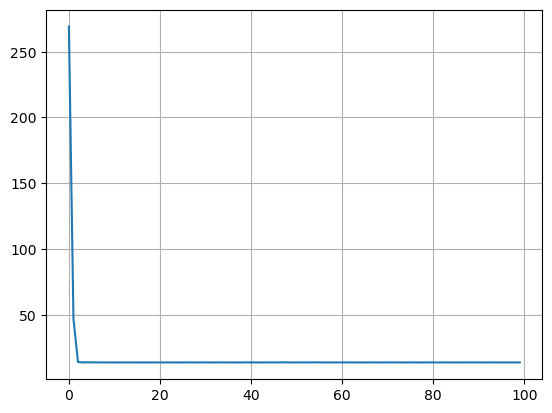

In [42]:
plt.plot(range(100), loss)
plt.grid(True)

In [43]:
val_input[0:1,:,:,:].shape

torch.Size([1, 2, 30, 30])

In [44]:
model.forward(val_input[0:10,:,:,:])

tensor([[2.2113],
        [2.2129],
        [2.2119],
        [2.2123],
        [2.2123],
        [2.2146],
        [2.2155],
        [2.2132],
        [2.2128],
        [2.2112]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
val_target[1:10]

tensor([2.0700, 3.3700, 2.8500, 1.9700, 3.1900, 3.2600, 2.5200, 2.2200, 2.1700],
       device='cuda:0')